In [66]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

In [67]:
def load_models():
    """
    Load both trained models
    """
    try:
        long_term_model = joblib.load('best_yield_predictor_for_long_trem_patterns.pkl')
        seasonal_model = joblib.load('best_yield_predictor_for_seasonal_patterns.pkl')
        return long_term_model, seasonal_model
    except Exception as e:
        print(f"Error loading models: {str(e)}")
        return None, None

In [68]:
def get_weather_data(city="Kuliyapitiya", api_key="5dd16e6569f3cdae6509d32002b9dc67"):
    """
    Get weather data from OpenWeatherMap API
    """
    base_url = "http://api.openweathermap.org/data/2.5/weather"
    
    params = {
        'q': city,
        'appid': api_key,
        'units': 'metric'
    }
    
    try:
        response = requests.get(base_url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        weather_data = {
            'Temperature (°C)': data['main']['temp'],
            'Humidity (%)': data['main']['humidity'],
            'Rainfall (mm)': data.get('rain', {}).get('24h', 0),
            'Weather Description': data['weather'][0]['description']
        }
        return weather_data, True
            
    except Exception as e:
        print(f"Error getting weather data: {str(e)}")
        return None, False

In [69]:
def ensemble_predict(soil_data, weather_data=None, weights=None):
    """
    Make predictions using both models and combine them
    """
    long_term_model, seasonal_model = load_models()
    
    if long_term_model is None or seasonal_model is None:
        return None
        
    if weights is None:
        weights = (0.6, 0.4)
        
    if weather_data is None:
        weather_data, success = get_weather_data()
        if not success:
            return None
            
    try:
        # Prepare input data for long-term model
        input_data = pd.DataFrame({
            'Soil Moisture (10 cm) (%)': [soil_data['sm_10']],
            'Soil Moisture (20 cm) (%)': [soil_data['sm_20']],
            'Soil Moisture (30 cm) (%)': [soil_data['sm_30']],
            'Plant Age (years)': [soil_data['age']],
            'Temperature (°C)': [weather_data['Temperature (°C)']],
            'Humidity (%)': [weather_data['Humidity (%)']],
            'Rainfall (mm)': [weather_data['Rainfall (mm)']],
            'Soil Type (Numeric)': [soil_data['soil_type']]
        })
        
        # Get prediction from long-term model
        long_term_pred = long_term_model.predict(input_data)[0]
        
        # Prepare time series data for seasonal model
        current_date = pd.Timestamp.now()
        ts_data = pd.DataFrame(input_data.iloc[0]).T
        ts_data.index = [current_date]
        
        # Get prediction from seasonal model
        try:
            seasonal_pred = seasonal_model.forecast(steps=1)[0]
        except:
            try:
                seasonal_pred = seasonal_model.predict(ts_data)[0]
            except:
                print("Warning: Could not get seasonal prediction, using long-term prediction instead")
                seasonal_pred = long_term_pred
        
        # Combine predictions using weighted average
        ensemble_pred = (weights[0] * long_term_pred + weights[1] * seasonal_pred)
        
        # Calculate confidence score based on model agreement
        prediction_diff = abs(long_term_pred - seasonal_pred)
        max_diff = max(long_term_pred, seasonal_pred)
        confidence_score = (1 - prediction_diff/max_diff) * 100 if max_diff > 0 else 100
        
        return {
            'ensemble_prediction': ensemble_pred,
            'long_term_prediction': long_term_pred,
            'seasonal_prediction': seasonal_pred,
            'confidence_score': confidence_score,
            'weights': weights
        }
        
    except Exception as e:
        print(f"Error making prediction: {str(e)}")
        print(f"Error type: {type(e)}")
        import traceback
        print("Full traceback:")
        traceback.print_exc()
        return None

In [70]:
def check_models():
    """
    Diagnose loaded models
    """
    long_term_model, seasonal_model = load_models()
    
    print("Long-term model:")
    print(f"Type: {type(long_term_model)}")
    print(f"Attributes: {dir(long_term_model)}")
    print("\nSeasonal model:")
    print(f"Type: {type(seasonal_model)}")
    print(f"Attributes: {dir(seasonal_model)}")

# Run diagnostics
check_models()

Long-term model:
Type: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
Attributes: ['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_clone__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_build_request_for_signature', '_check_feature_names', '_check_n_features', '_compute_oob_predictions', '_compute_partial_dependence_recursion', '_estimator_type', '_get_default_requests', '_get_metadata_request', '_get_oob_predictions', '_get_param_names', '_get_tags', '_make_estimator', '_more_tags', '_parameter_constraints', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_required_pa

In [71]:
def plot_predictions(predictions):
    """
    Visualize the predictions from both models and the ensemble
    """
    plt.figure(figsize=(12, 6))
    
    # Create bar plot
    models = ['Long-term Model', 'Seasonal Model', 'Ensemble Prediction']
    values = [predictions['long_term_prediction'], 
              predictions['seasonal_prediction'],
              predictions['ensemble_prediction']]
    
    bars = plt.bar(models, values)
    
    # Customize the plot
    plt.title('Coconut Yield Predictions Comparison')
    plt.ylabel('Predicted Yield')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom')
    
    # Add confidence score
    plt.text(0.02, 0.95, f'Confidence Score: {predictions["confidence_score"]:.1f}%',
             transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.show()


Prediction Results:
--------------------------------------------------
Long-term Model Prediction: 304.63
Seasonal Model Prediction: 325.16
Ensemble Prediction: 312.84
Confidence Score: 93.69%
Weights Used: (0.6, 0.4)

Prediction Time: 2024-12-d 17:45:46


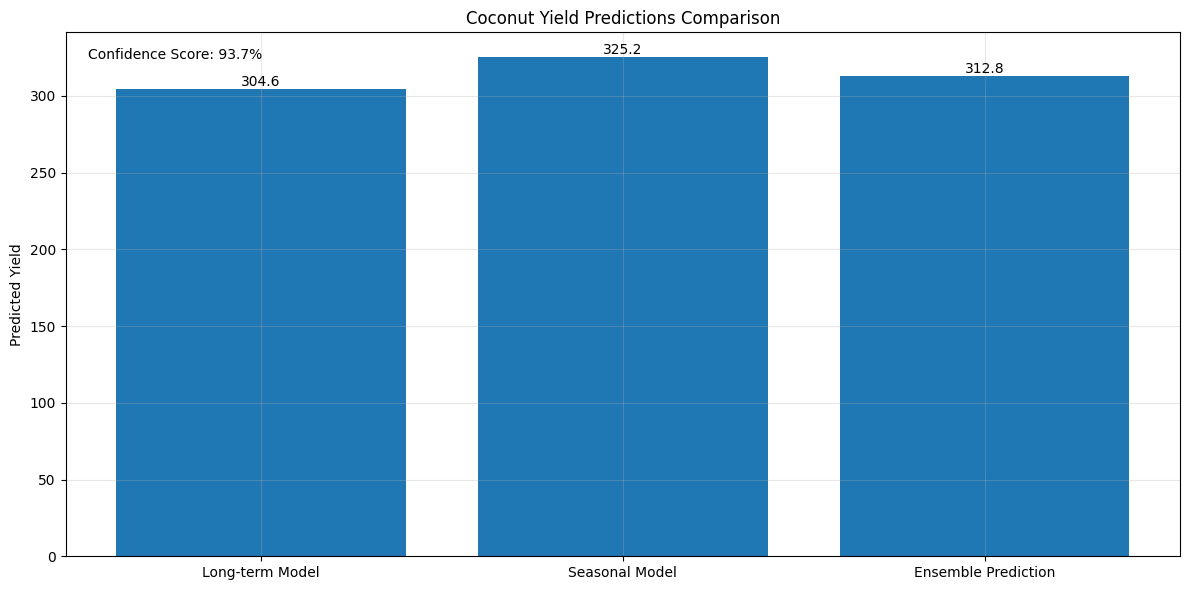

In [72]:
# Example input data
soil_data = {
    'sm_10': 19.89,  # Soil moisture at 10cm depth
    'sm_20': 41.67,  # Soil moisture at 20cm depth
    'sm_30': 34.82,  # Soil moisture at 30cm depth
    'age': 3,        # Plant age in years
    'soil_type': 2   # Sandy Loam soil type
}

# Test prediction with example data
predictions = ensemble_predict(soil_data)

if predictions:
    print("\nPrediction Results:")
    print("-" * 50)
    print(f"Long-term Model Prediction: {predictions['long_term_prediction']:.2f}")
    print(f"Seasonal Model Prediction: {predictions['seasonal_prediction']:.2f}")
    print(f"Ensemble Prediction: {predictions['ensemble_prediction']:.2f}")
    print(f"Confidence Score: {predictions['confidence_score']:.2f}%")
    print(f"Weights Used: {predictions['weights']}")
    print("\nPrediction Time:", datetime.now().strftime("%Y-%m-d %H:%M:%S"))
    
    # Plot the predictions
    plot_predictions(predictions)

In [73]:
weight_combinations = [
    (0.7, 0.3),  # More emphasis on long-term patterns
    (0.5, 0.5),  # Equal weights
    (0.3, 0.7)   # More emphasis on seasonal patterns
]

for weights in weight_combinations:
    print(f"\nTesting with weights: {weights}")
    predictions = ensemble_predict(soil_data, weights=weights)
    
    if predictions:
        print(f"Ensemble Prediction: {predictions['ensemble_prediction']:.2f}")
        print(f"Confidence Score: {predictions['confidence_score']:.2f}%")


Testing with weights: (0.7, 0.3)
Ensemble Prediction: 310.79
Confidence Score: 93.69%

Testing with weights: (0.5, 0.5)
Ensemble Prediction: 314.89
Confidence Score: 93.69%

Testing with weights: (0.3, 0.7)
Ensemble Prediction: 319.00
Confidence Score: 93.69%


In [81]:
class EnsembleYieldPredictor:
    def __init__(self, weights=(0.6, 0.4)):
        self.weights = weights
        self.long_term_model = None
        self.seasonal_model = None
        self.load_models()
    
    def load_models(self):
        self.long_term_model, self.seasonal_model = load_models()
    
    def predict(self, soil_data, weather_data=None):
        return ensemble_predict(soil_data, weather_data, self.weights)

# Save the ensemble model
ensemble_model = EnsembleYieldPredictor()
joblib.dump(ensemble_model, 'ensemble_yield_predictor.pkl')
print("\nEnsemble model saved as 'ensemble_yield_predictor.pkl'")
print(ensemble_model)


Ensemble model saved as 'ensemble_yield_predictor.pkl'
